# **Long Short Term Memory** 

## Load Packages

In [1]:
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV


## Load Dataset

In [2]:
# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load the datase
df = pd.read_csv('CPU_Data.csv', parse_dates=True)

df.head()

,_time,ip-10-10-20-161
0,2017-07-19T00:00:00.000+0000,15.904462
1,2017-07-20T00:00:00.000+0000,16.393611
2,2017-07-21T00:00:00.000+0000,16.775417
3,2017-07-22T00:00:00.000+0000,16.912917
4,2017-07-23T00:00:00.000+0000,16.883750


# Data Preprocessing

In [4]:
# Extract the date and CPU columns
date_column = '_time'
cpu_columns = ['ip-10-10-20-161']


# Extract the relevant data
data = df[[date_column] + cpu_columns]

# Set the date column as the index
#data[date_column] = pd.to_datetime(data[date_column])
data.loc[:, date_column] = pd.to_datetime(data[date_column])
data.set_index(date_column, inplace=True)



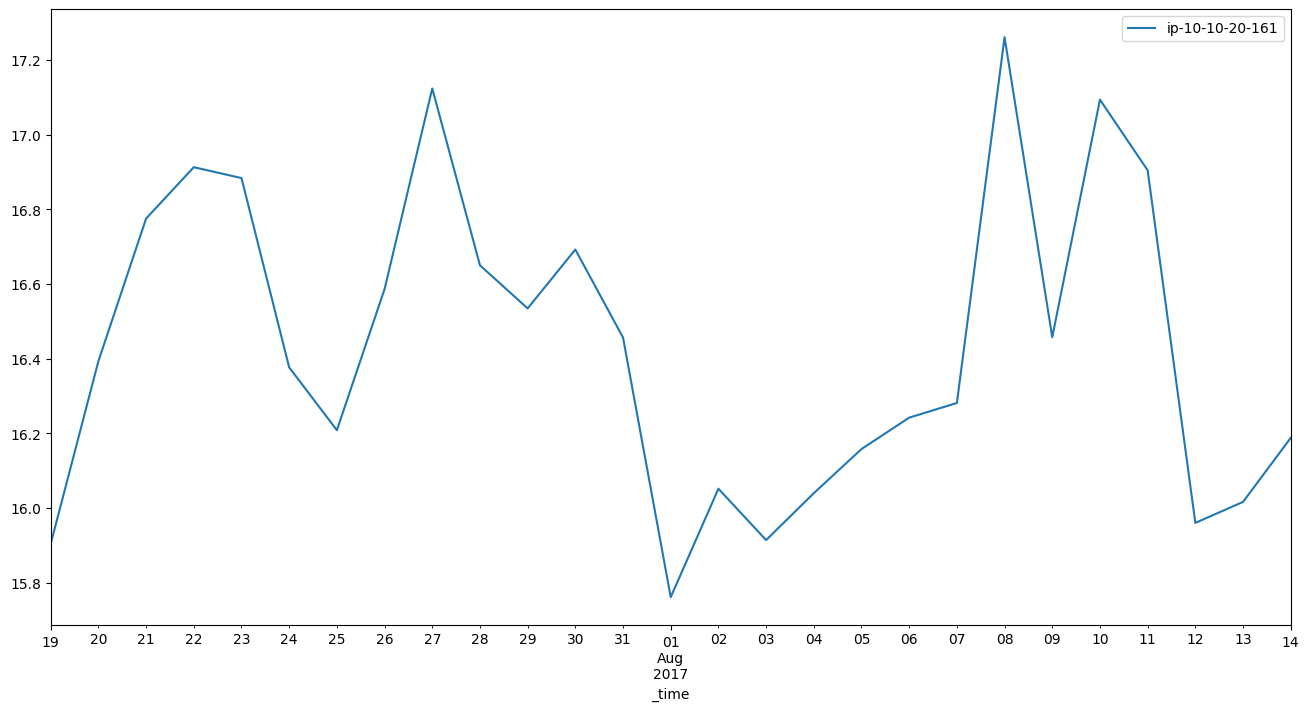

In [5]:
data.plot(figsize=(16, 8))
plt.show()

# Normalization


In [6]:
# Normalize the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Splitting Train Test

In [7]:

# Prepare the training and testing datasets
train_size = int(len(scaled_data) * 0.67)
test_size = len(df) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]
#train_data, test_data = scaled_data[:train_size], scaled_data[-train_size:]

print(len(train_data), len(test_data))



18 9


# Create Time Series Dataset

Lookback is a parameter to define the number of previous time to use as input variable to predict the next preiod.

In [8]:

# Define a function to create the time series dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
        #Y.append(dataset.iloc[i+look_back].to_numpy())
    return np.array(X), np.array(Y)   





In [9]:

# Set the look-back window (adjust as needed)
look_back = 1

train_X, train_Y = create_dataset(train_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
testX = np.reshape(test_X, (test_X.shape[0], 1,  test_X.shape[1]))


In [10]:

print("Train X shape: ", train_X.shape)
print("Test X shape: ", test_X.shape)
print("Train Y shape: ", train_Y.shape)
print("Test Y shape: ", test_Y.shape)


Train X shape:  (17, 1, 1)
Test X shape:  (8, 1, 1)
Train Y shape:  (17, 1)
Test Y shape:  (8, 1)


# Build and Train the LSTM Model
<https://www.projectpro.io/article/lstm-model/832>

In [24]:
# Define the LSTM model
def create_model(optimizer='adam', dropout_rate=0.0, hidden_nodes=32, units=4):
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, len(cpu_columns))))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_nodes))
    model.add(Dense(len(cpu_columns)))  # Output layer adjusts for the number of CPUs
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


In [25]:
# Define hyperparameters for tuning
param_grid = {
    'optimizer': ['adam', 'rmsprop', 'SGD'],
    'dropout_rate': [0.0, 0.2],
    'batch_size': [32, 64],
    'hidden_nodes': [16, 32, 64],
    'units': [4, 32, 64],
    'epochs': [10, 100]
}

In [26]:
# Wrap the model using KerasRegressor for compatibility with scikit-learn
model = KerasRegressor(model=create_model, dropout_rate=0.0, units= 4, hidden_nodes=16, verbose=0)

In [27]:
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=3, n_iter=1)
#random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, n_iter=1)
random_search_result = random_search.fit(train_X, train_Y) 

In [28]:
# Get the best parameters
best_params = random_search_result.best_params_
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

Best Hyperparameters:
units: 32
optimizer: SGD
hidden_nodes: 64
epochs: 100
dropout_rate: 0.2
batch_size: 32


In [30]:
# Create and train the final model with the best parameters
final_model = create_model(units=best_params['units'], dropout_rate=best_params['dropout_rate'], 
                           hidden_nodes=best_params['hidden_nodes'])
history = final_model.fit(train_X, train_Y, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)




In [31]:
final_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 32)                4352      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6529 (25.50 KB)
Trainable params: 6529 (25.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Make Predictions and Evaluate

In [32]:
test_Y.shape

(8, 1)

In [33]:
# Make predictions
test_predict = final_model.predict(test_X)

# Inverse transform predictions to the original scale
test_predict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform(test_Y)


# Calculate evaluation metrics for all CPUs
mse = mean_squared_error(test_Y, test_predict)
mae = mean_absolute_error(test_Y, test_predict)
mape = mean_absolute_percentage_error(test_Y, test_predict) * 100
r_squared = r2_score(test_Y, test_predict)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')
print(f'R-squared (R^2): {r_squared:.4f}')

1/1 [==============================] - 0s 246ms/step
Mean Squared Error (MSE): 0.2320
Mean Absolute Error (MAE): 0.3921
Mean Absolute Percentage Error (MAPE): 2.3538%
R-squared (R^2): -0.0523


In [34]:
test_predict.shape

(8, 1)

In [35]:
print(len(test_Y))
print(len(test_predict))
print(test_Y.shape)
print(test_predict.shape)

8
8
(8, 1)
(8, 1)


In [36]:
new_df = pd.DataFrame({
    'Actual': [item[0] for item in test_Y],
    'Predicted': [item[0] for item in test_predict]
})

new_df.head(10)

,Actual,Predicted
0,16.281528,16.374706
1,17.261042,16.391008
2,16.457639,16.802362
3,17.093681,16.464432
4,16.904653,16.731787
5,15.960417,16.652109
6,16.016667,16.258274
7,16.188000,16.281403


# Plot the Actual vs. Predicted Values

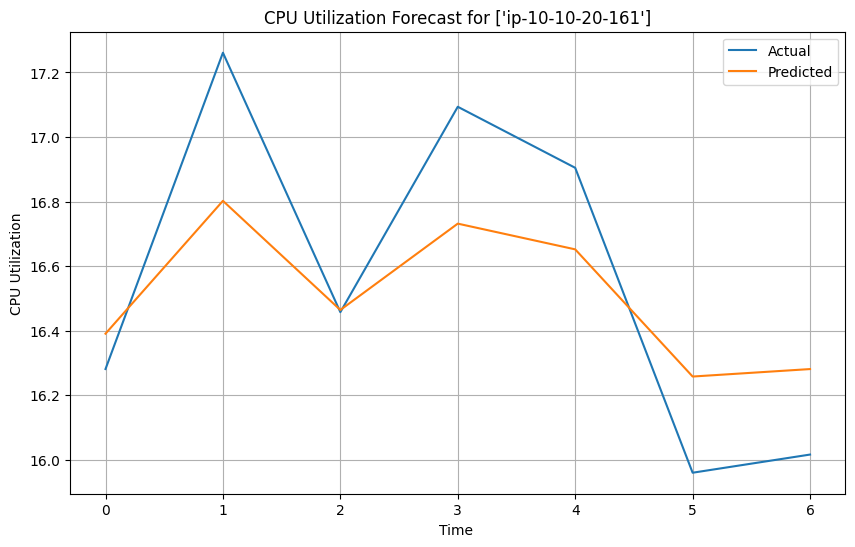

In [38]:
# Plot the actual vs. predicted values for all CPUs

plt.figure(figsize=(10, 6))
plt.plot(test_Y[:-1], label=f'Actual')
plt.plot(test_predict[1:], label=f'Predicted')
plt.xlabel('Time ')
plt.ylabel('CPU Utilization')
plt.title(f'CPU Utilization Forecast for {cpu_columns}')
plt.legend()
plt.grid(True)

plt.show()